In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(3456)


#### Hidden Layer: $h_j = \max{(W^{y}y_{j} + W^{t}t_{j} + W^{h}h_{j-1} + b_{h},0)} $


#### Marker Generation: $P(y_{j+1}=k\mid h_{j}) = \frac{\exp(V_{k,:}^{y}h_{j} + b_{k}^{y})}{\sum_{k=1}^{K} \exp(V_{k,:}^{y}h_{j} + b_{k}^{y})} = \sigma(z)_{k}$ where $\sigma$ is softmax function and $z$ is the vector $ V^{y}h_{j} + b^{y}$ 


#### Conditional Density: $f^{*}(t) = \exp\{{v^{t}}^\top.h_{j} + w^t(t-t_{j}) + b^{t} + \frac{1}{w^t}\exp({v^{t}}^\top.h_{j} + b^{t}) -\frac{1}{w^t}\exp({v^{t}}^\top.h_{j} + w^t(t-t_{j}) + b^{t} )\} $

In [68]:
class Rmtpp(nn.Module):
    
    def __init__(self):
        self.N = 100000
        #marker_dim equals to time_dim
        super(Rmtpp, self).__init__()
        process_dim = 2
        marker_dim = 2
        #linear transformation
        self.lin_op = nn.Linear(process_dim+2,1) 
        self.vt = nn.Linear(1,1)
        
        #embedding
        self.embedding = nn.Embedding(process_dim+1, 2, padding_idx=process_dim)
        
        #weights
        self.w_t = torch.rand(1)
        self.V_y = torch.rand(marker_dim) #marker dim = number of markers 
        self.b_y = torch.rand(marker_dim) #bias
        
    #compute integral of t*fstart(t) between tj and +infinity using trapezoidal rule
    def next_time(self,tj,hj):
        T = tj + 100 #maximum time
        Deltat = (T-tj)/self.N
        dt = torch.tensor([tj]+[Deltat]*self.N)
        dt = torch.cumsum(dt,dim=0)
        df = dt * self.fstart(dt,tj,hj) 
        #normalization factor
        nf = self.normalization_factor(tj,hj)
        df = df/nf
        integral = ((df[1:] + df[:-1])/2) * Deltat
        return torch.sum(integral)
    
    def normalization_factor(self,tj,hj):
        T = tj + 100 #maximum time
        Deltat = (T-tj)/self.N
        dt = torch.tensor([tj]+[Deltat]*self.N)
        dt = torch.cumsum(dt,dim=0)
        df = self.fstart(dt,tj,hj)
        integral = ((df[1:] + df[:-1])/2) * Deltat
        return torch.sum(integral)
        
        
    
    #compute the function fstar
    def fstart(self,t,tj,hj):  
        return (t>tj).float() * torch.exp(self.vt(hj) - torch.exp(self.w_t)*(t-tj) + 1/torch.exp(self.w_t) * (torch.exp(self.vt(hj) - torch.exp(self.w_t)*(t-tj)) - torch.exp(self.vt(hj))))
            
    def proba_distribution(self,hj):
        soft_max = nn.Softmax(dim=0) #softmax of rows
        return soft_max(self.V_y*hj + self.b_y)
        
    def forward(self, time, marker, hidden_state):    
        #First compute next time
        tj = time
        time = self.next_time(time,hidden_state).unsqueeze(-1)
        fstar = self.fstart(time,tj,hidden_state)
       
        #Then next marker distribution 
        prob = self.proba_distribution(hidden_state)
        
        #marker = marker.float()
        marker = self.embedding(marker)[0]
        input_ = torch.cat((marker, time, hidden_state), dim=0)
        hidden_state = F.relu(self.lin_op(input_))
        
        return prob, fstar, hidden_state
    
    
    def log_likelihood(self,time_sequence,marker_sequence):
        marker_ = marker_sequence
        time_sequence = time_sequence.unsqueeze(-1)
        marker_sequence = marker_sequence.unsqueeze(-1)
        loss = 0
        hidden_state = torch.zeros(1)
        for i in range(time_sequence.shape[0]-1):
            time = time_sequence[i]
            marker__ = marker_[i+1]
            marker = marker_sequence[i]
            prob, fstar, hidden_state = self(time,marker,hidden_state)
            loss += torch.log(prob[marker__]) + torch.log(fstar)
        
        return -1 * loss
    
    
    def train(self, seq_times, seq_types, seq_lengths, optimizer, epochs=10):
        #seq_times: time sequences
        #seq_types: type sequences
        #seq_length: keep track of length of each sequences

        n_sequences = seq_times.shape[0]
        epoch_range = tqdm.trange(epochs, ascii=True)
        losses = []
        for e in epoch_range:
            print("epochs {}  ------".format(e+1))
            epoch_losses = []
            loss = torch.zeros(1)
            for i in range(n_sequences):
                length = seq_lengths[i]
                evt_times = seq_times[i, :length]
                evt_types = seq_types[i, :length]
                loss += rnn.log_likelihood(evt_times, evt_types)
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
            print("loss: {}".format(loss.item()))
            losses.append(np.mean(epoch_losses))
        print("end -------------")  
        return losses

    def predict(self):
        
        
        return 0
                
        

In [49]:
%matplotlib inline

## Training:

In [50]:
import tqdm

In [97]:
import torch.optim as optim
import numpy as np


rnn = Rmtpp()

learning_rate = 0.05
optimizer = optim.Adam(rnn.parameters(), lr=learning_rate)


In [ ]:
seq_times = seq_times[:10]
seq_types = seq_types[:10]
seq_lengths = seq_lengths[:10]
losses = rnn.train(seq_times, seq_types, seq_lengths,optimizer ,epochs=20)






  0%|          | 0/20 [00:00<?, ?it/s]

epochs 1  ------







  5%|5         | 1/20 [00:16<05:21, 16.93s/it]

loss: 650.9888305664062
epochs 2  ------







 10%|#         | 2/20 [00:33<05:05, 16.97s/it]

loss: 640.352294921875
epochs 3  ------







 15%|#5        | 3/20 [00:51<04:48, 17.00s/it]

loss: 630.1393432617188
epochs 4  ------







 20%|##        | 4/20 [01:08<04:32, 17.04s/it]

loss: 620.070068359375
epochs 5  ------







 25%|##5       | 5/20 [01:24<04:13, 16.92s/it]

loss: 610.0313720703125
epochs 6  ------







 30%|###       | 6/20 [01:41<03:56, 16.88s/it]

loss: 599.9844360351562
epochs 7  ------







 35%|###5      | 7/20 [01:59<03:42, 17.09s/it]

loss: 589.9110107421875
epochs 8  ------


Text(0.5, 1.0, 'loss function of RMTPP model')

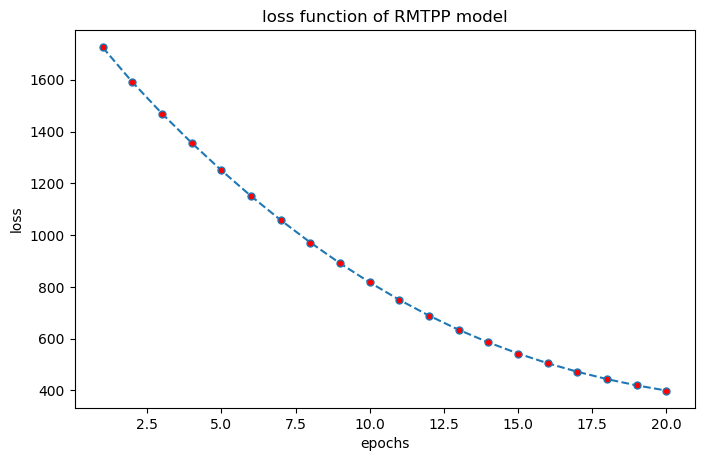

In [96]:
plt.figure(figsize=(8, 5), dpi=100)
plt.plot(range(1,21),losses, linestyle = "--",marker='.',markerfacecolor='red', markersize=10)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("loss function of RMTPP model")


0.9999999568648903


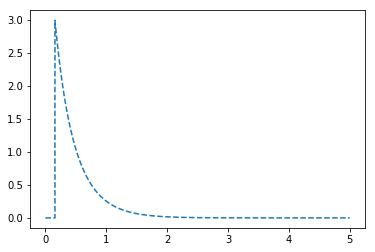

In [7]:
import numpy as np
#t = torch.linspace(0,100)
t = torch.linspace(0,5,100000)
tj = torch.tensor([0.1567])
hj = torch.tensor([1.56])
marker = torch.tensor([0.])
nf = rnn.normalization_factor(tj,hj)
fstar = rnn.fstart(t,tj,hj).detach().numpy()
delta = t.numpy()[1] - t.numpy()[0]
integrale_ = np.sum(fstar[1:] + fstar[:-1])/2 * delta
fstar  = fstar/integrale_
import matplotlib.pyplot as plt
integrale__ = np.sum(fstar[1:] + fstar[:-1])/2 * delta
print(integrale__)

plt.plot(t.numpy(),fstar, linestyle = "--")

# Tick.Hawkes

In [8]:
from tick.plot import plot_point_process
from tick.hawkes import SimuHawkes, HawkesKernelSumExp
import matplotlib.pyplot as plt

/anaconda3/lib/python3.6/site-packages/tick/base/__init__.py:18: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use('Agg')


#### 1 dimensional Hawkes process simulation using tick

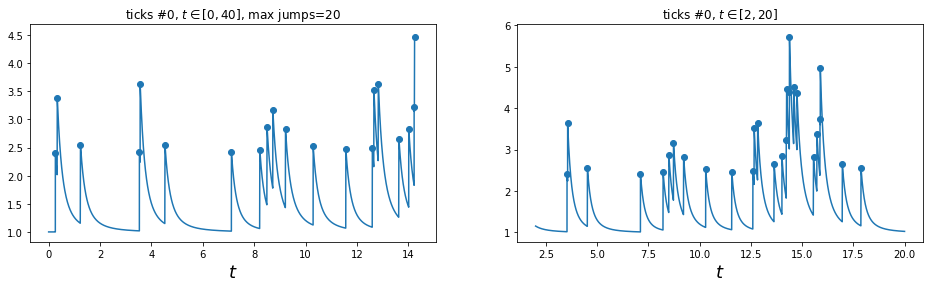

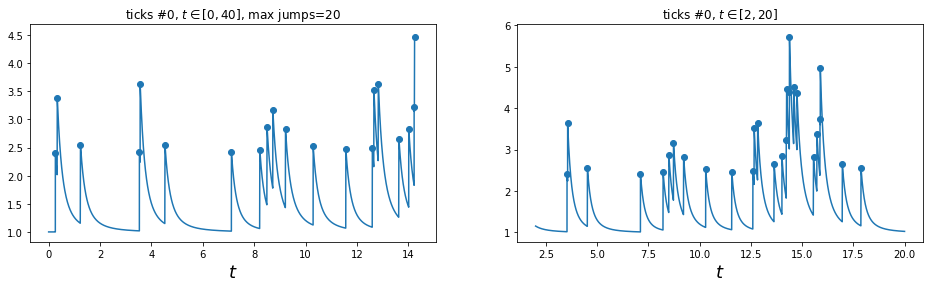

In [9]:
run_time = 40

hawkes = SimuHawkes(n_nodes=1, end_time=run_time, verbose=False, seed=1398)
kernel1 = HawkesKernelSumExp([.1, .2, .1], [1., 3., 7.])
hawkes.set_kernel(0, 0, kernel1)
hawkes.set_baseline(0, 1.)

dt = 0.01
hawkes.track_intensity(dt)
hawkes.simulate()
timestamps = hawkes.timestamps
intensity = hawkes.tracked_intensity
intensity_times = hawkes.intensity_tracked_times

_, ax = plt.subplots(1, 2, figsize=(16, 4))
plot_point_process(hawkes, n_points=50000, t_min=0, max_jumps=20, ax=ax[0])
plot_point_process(hawkes, n_points=50000, t_min=2, t_max=20, ax=ax[1])

In [10]:
def simulate_timestamps(end_time):
    # simulation 2 types of event for exemple selling or buying
    
    hawkes = SimuHawkes(n_nodes=2, end_time=end_time, verbose=False, seed=1398)
    kernel = HawkesKernelSumExp([.1, .2, .1], [1., 3., 7.])
    kernel1 = HawkesKernelSumExp([.2, .3, .1], [1., 3., 7.])
    
    hawkes.set_kernel(0, 0, kernel)
    hawkes.set_kernel(0, 1, kernel)
    hawkes.set_kernel(1, 0, kernel)
    hawkes.set_kernel(1, 1, kernel)
    
    hawkes.set_baseline(0, .8)
    hawkes.set_baseline(1, 1.)

    dt = 0.1
    hawkes.track_intensity(dt)
    hawkes.simulate()
    timestamps = hawkes.timestamps
    t0 = timestamps[0]
    t1 = timestamps[1]
    
    t = []
    marker = []
    n0 = len(t0)
    n1 = len(t1)
    i = 0
    j = 0
    while(i<n0 and j<n1):
        if(t0[i]<t1[j]):
            t.append(t0[i])
            marker.append(0)
            i += 1
        else:
            t.append(t1[j])
            marker.append(1)
            j += 1
    if(i==n0):
        for k in range(n0,n1):
            t.append(t1[k])
            marker.append(1)
    else:
        for k in range(n1,n0):
            t.append(t0[k])
            marker.append(0)
        
        
   
    return t,marker


 

### Training with simulated hawkes

In [11]:
import pickle
import os
import glob
import sys

In [12]:
# Add parent dir to interpreter path
nb_dir = os.path.split(os.getcwd())[0]
print("Notebook dir {:}".format(nb_dir))
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
print("Python interpreter path:")
for path in sys.path:
    print(path)

Notebook dir /Users/cheikh/Desktop/Hawkes process/map511-p3a
Python interpreter path:

/anaconda3/lib/python36.zip
/anaconda3/lib/python3.6
/anaconda3/lib/python3.6/lib-dynload
/anaconda3/lib/python3.6/site-packages
/anaconda3/lib/python3.6/site-packages/aeosa
/anaconda3/lib/python3.6/site-packages/pointprocesses-0.3.0-py3.6-macosx-10.7-x86_64.egg
/anaconda3/lib/python3.6/site-packages/IPython/extensions
/Users/cheikh/.ipython
/Users/cheikh/Desktop/Hawkes process/map511-p3a


In [17]:
SYNTH_DATA_FILES = glob.glob('../data/simulated/*.pkl')

chosen_data_file = SYNTH_DATA_FILES[0]
print(chosen_data_file)

from utils.load_synth_data import process_loaded_sequences, one_hot_embedding


../data/simulated/hawkes_synthetic_exp_2d_20181206-160527.pkl


In [19]:
# Load data simulated using tick

print("Loading 2-dimensional Hawkes data.")

with open(chosen_data_file, "rb") as f:
    loaded_hawkes_data = pickle.load(f)

print(loaded_hawkes_data.keys())

tmax = loaded_hawkes_data['tmax']


seq_times, seq_types, seq_lengths = process_loaded_sequences(
    loaded_hawkes_data, 2, tmax)

Loading 2-dimensional Hawkes data.
dict_keys(['mu', 'alpha', 'decay', 'tmax', 'timestamps', 'types', 'lengths'])


In [21]:
seq_types.shape

torch.Size([1000, 91])

In [22]:
sequences = loaded_hawkes_data["timestamps"]
types = loaded_hawkes_data["types"]
sequences[0].tolist()
time_sequences = [sequences[i].tolist() for i in range(len(sequences))]

marker_sequences = [types[i].tolist() for i in range(len(sequences))]

